<a href="https://colab.research.google.com/github/seidmutant/retention-analysis/blob/main/retention_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# @title Google Collab Notebook
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'ADD_PROJECT_ID_HERE' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Job ID inserted based on the query results selected to explore
job_id = 'ADD_JOB_ID_HERE'


In [21]:
# Running this code will display the query used to generate your previous job
job = client.get_job(job_id)
print(job.query)

WITH transactions AS (
  SELECT from_address, DATE(block_timestamp) AS created_at
  FROM `bigquery-public-data.crypto_ethereum.transactions`
  WHERE DATE(block_timestamp) >= '2022-01-01'
),

cohort AS (
  SELECT 
    from_address,
    MIN(
      CAST(FORMAT_DATETIME('%Y-%m', PARSE_DATETIME('%Y-%m-%d', CAST(DATE(created_at) AS STRING))) || '-01' AS DATE)
    ) AS cohort_month
  FROM transactions
  GROUP BY 1
),

cohort_size AS (
  SELECT
    cohort_month,
    COUNT(1) as num_users
  FROM cohort
  GROUP BY cohort_month
),

user_activities AS (
  SELECT
    DATE_DIFF(
      EXTRACT(DATE from timestamp(created_at)),
      cohort_month,
      MONTH
    ) as month_number,
    A.from_address
  FROM transactions AS A
  LEFT JOIN cohort C 
  ON A.from_address = C.from_address
  GROUP BY 2, 1
),

retention_table AS (
  SELECT
    cohort_month,
    A.month_number,
    COUNT(1) as num_users
  FROM user_activities A
  LEFT JOIN cohort C 
  ON A.from_address = C.from_address
  GROUP BY 1, 2  
)

SEL

In [22]:
# Tranform results to a dataframe
results = job.to_dataframe()
results.head()

,cohort_month,total_users,month_number,percentage
0,2022-01-01,5402274,0,100.00
1,2022-01-01,5402274,1,33.08
2,2022-01-01,5402274,2,32.62
3,2022-01-01,5402274,3,23.16
4,2022-01-01,5402274,4,22.43


In [23]:
# Pivot data
results_pivot = pd.pivot_table(results, values='percentage', index=['cohort_month'], columns=['month_number'], aggfunc=np.sum)
results_pivot.head()

month_number,0,1,2,3,4,5,6,7,8,9,10
cohort_month,,,,,,,,,,,
2022-01-01,100.0,33.08,32.62,23.16,22.43,16.53,19.14,16.21,14.99,11.42,8.12
2022-02-01,100.0,20.85,13.45,13.53,9.25,14.41,13.84,11.45,6.58,3.70,NaN
2022-03-01,100.0,11.17,8.70,6.15,9.43,8.60,9.03,5.14,2.81,NaN,NaN
2022-04-01,100.0,14.92,8.55,11.18,10.37,9.43,5.93,3.18,NaN,NaN,NaN
2022-05-01,100.0,10.94,11.31,9.07,8.22,5.35,3.27,NaN,NaN,NaN,NaN


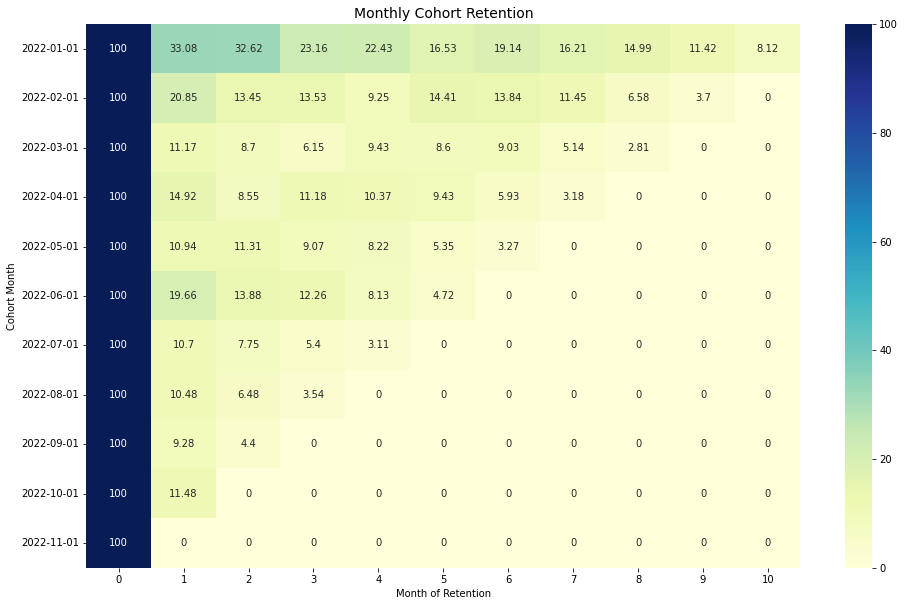

In [24]:
# Initialize the figure
plt.figure(figsize=(16, 10))

# Add a title
plt.title('Monthly Cohort Retention', fontsize = 14)

# Creating the heatmap
sns.heatmap(results_pivot.fillna(0), annot = True,vmin = 0.0, vmax =100, cmap="YlGnBu", fmt='g')

# Labels and axis
plt.ylabel('Cohort Month')
plt.xlabel('Month of Retention')
plt.yticks(rotation='360')

# Display plot
plt.show()